# Analyza EMM pomoci foton-korelacni metody vcetne odhadu nejistot

## Odhad sigmy bodů histogramu

Nejprve se chystám odhadnout sigmu naměřených histogramů. Tzn. měření na picoharpu.

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

Vyberu histogram s nejmenším MM

In [3]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

# frekvence buzeni pasti

drive_freq = 1/T_trig
Omega = 2*np.pi * drive_freq
drive_freq

30032035.976450287

In [4]:
# funkce vracejici residua
def fit_resid(x, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) - x[2])
    return S - S_fit

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points - x[2])

In [5]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    x[:,i] = fit.x
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    

In [7]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 14
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

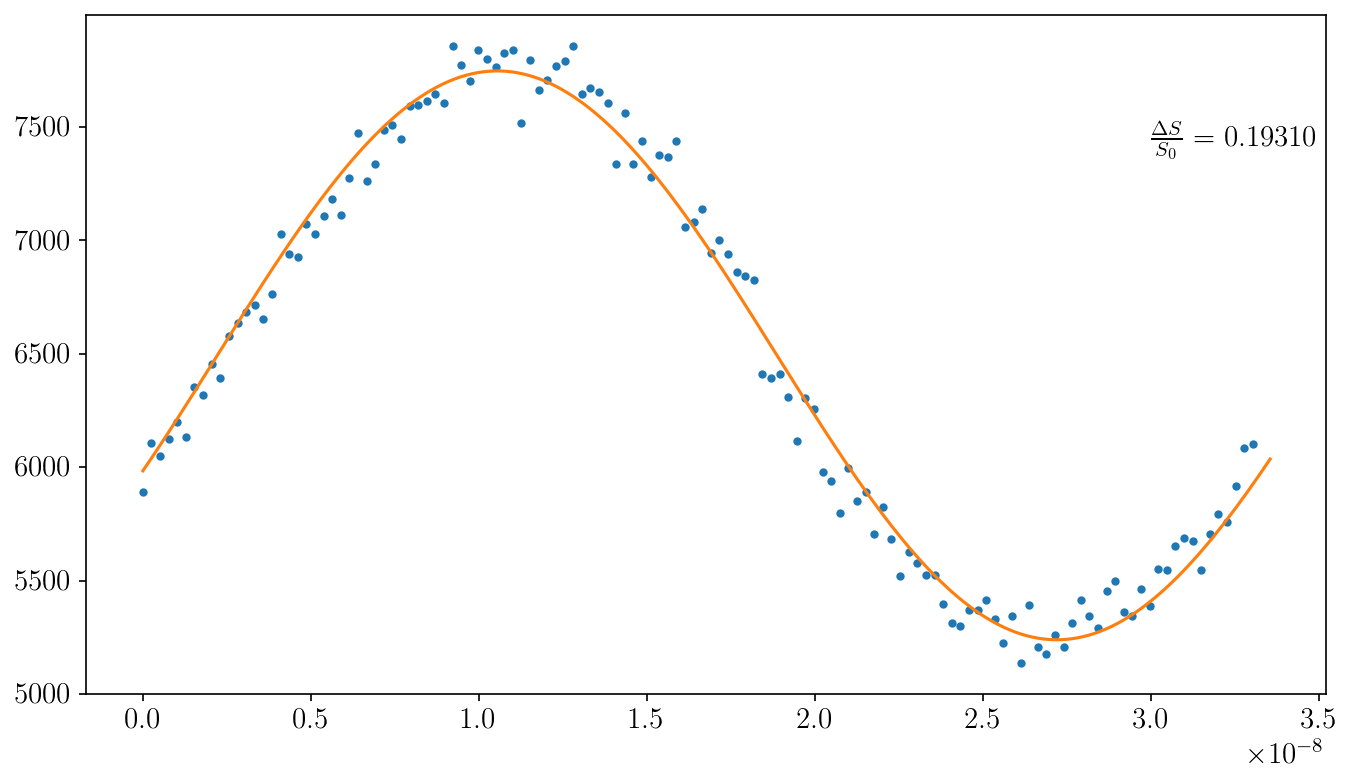

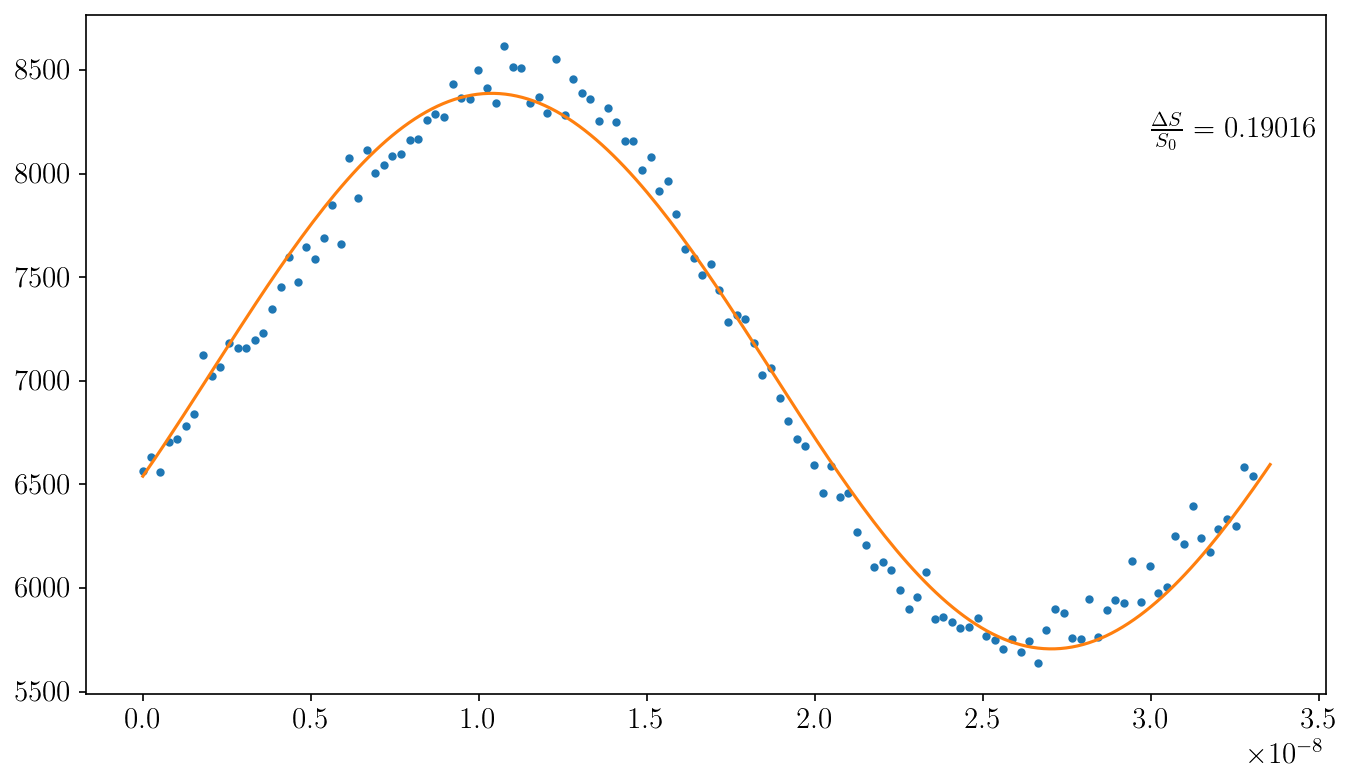

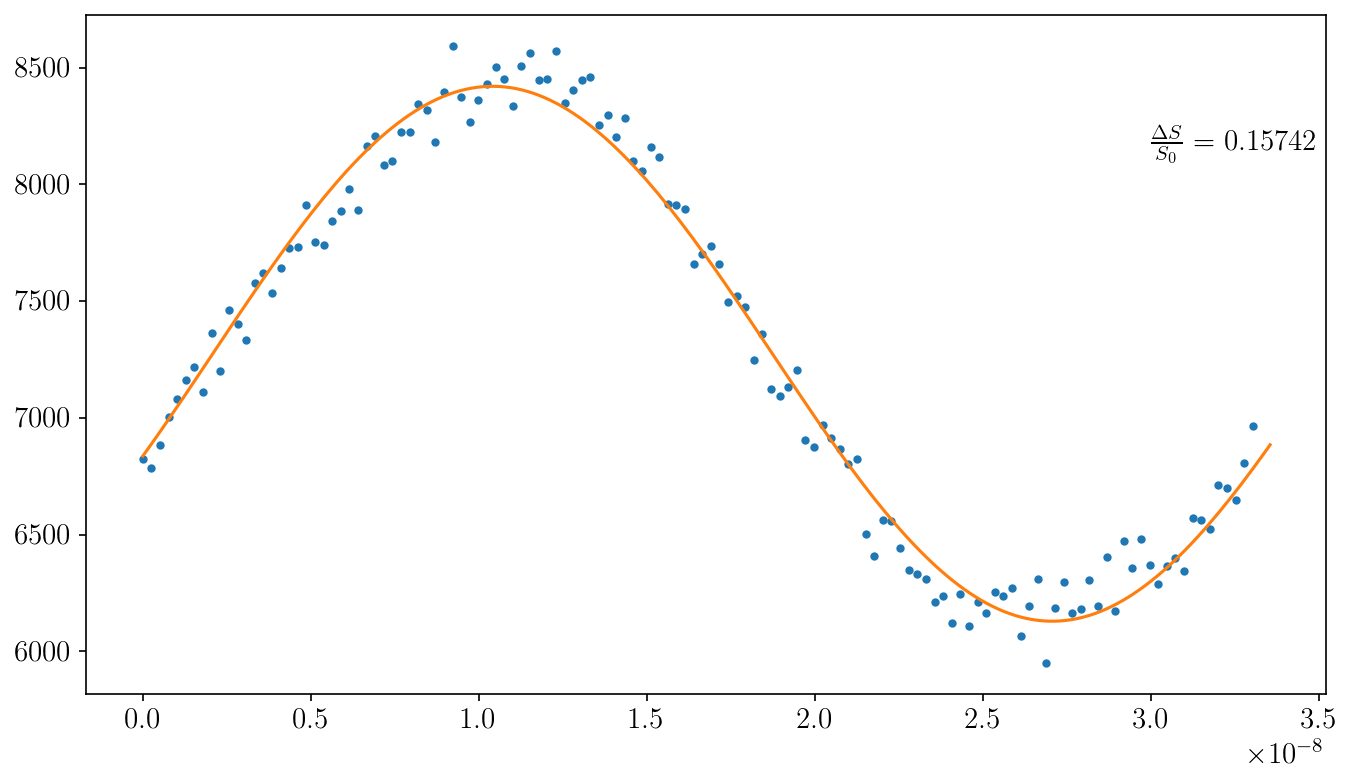

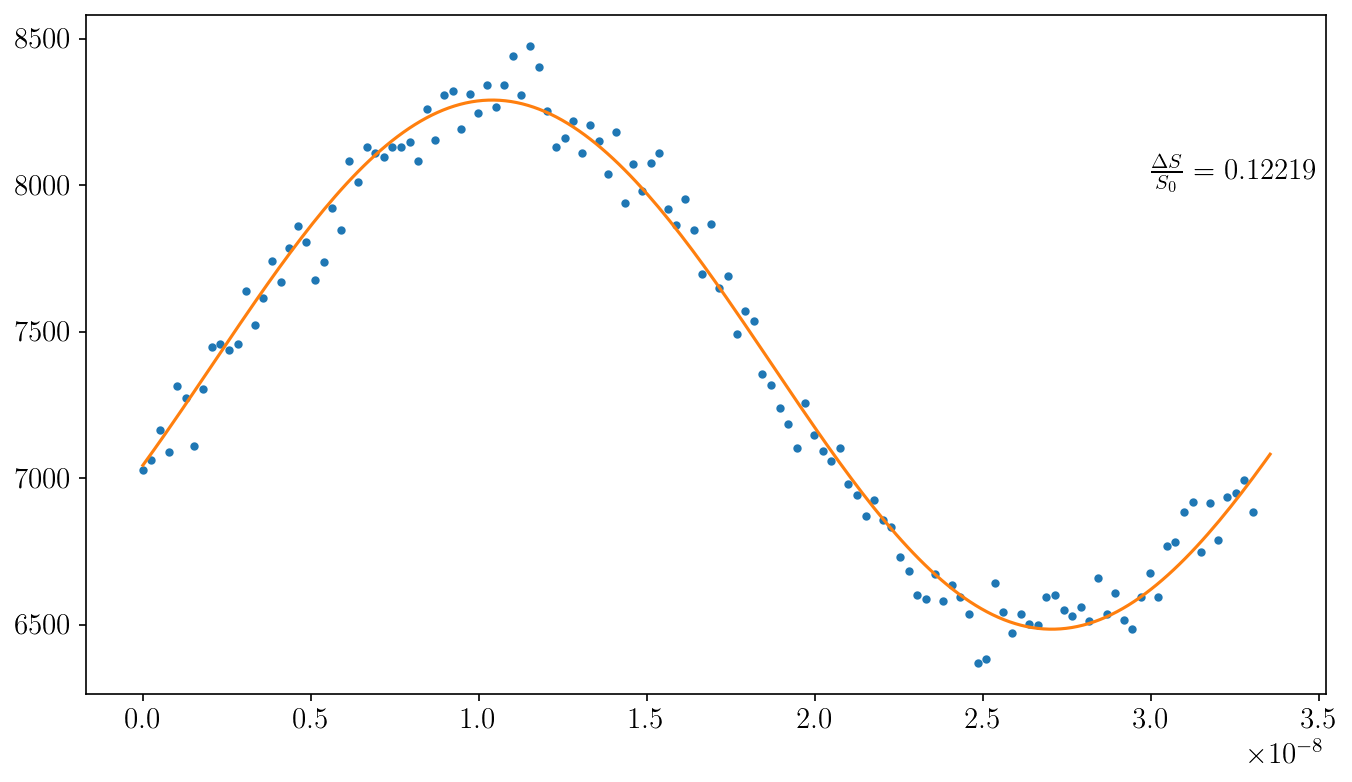

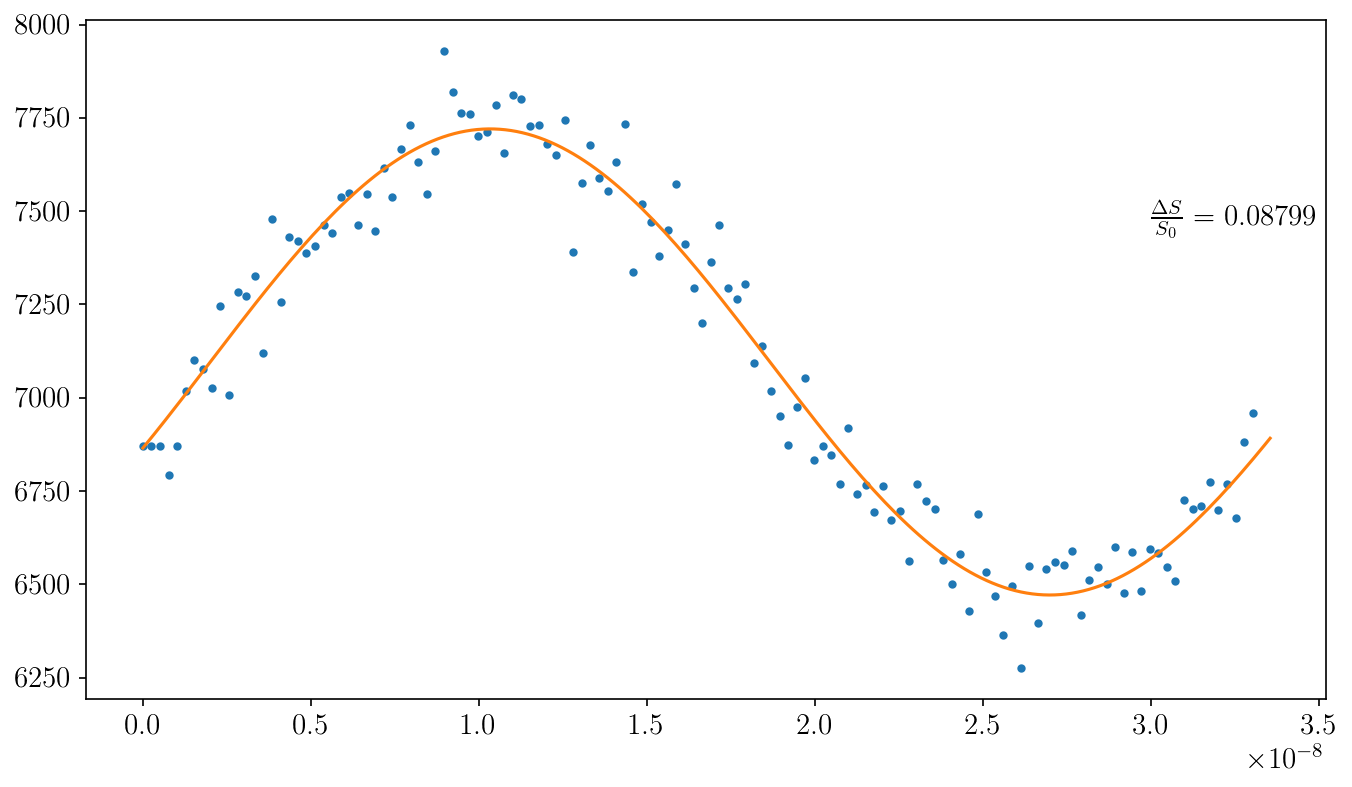

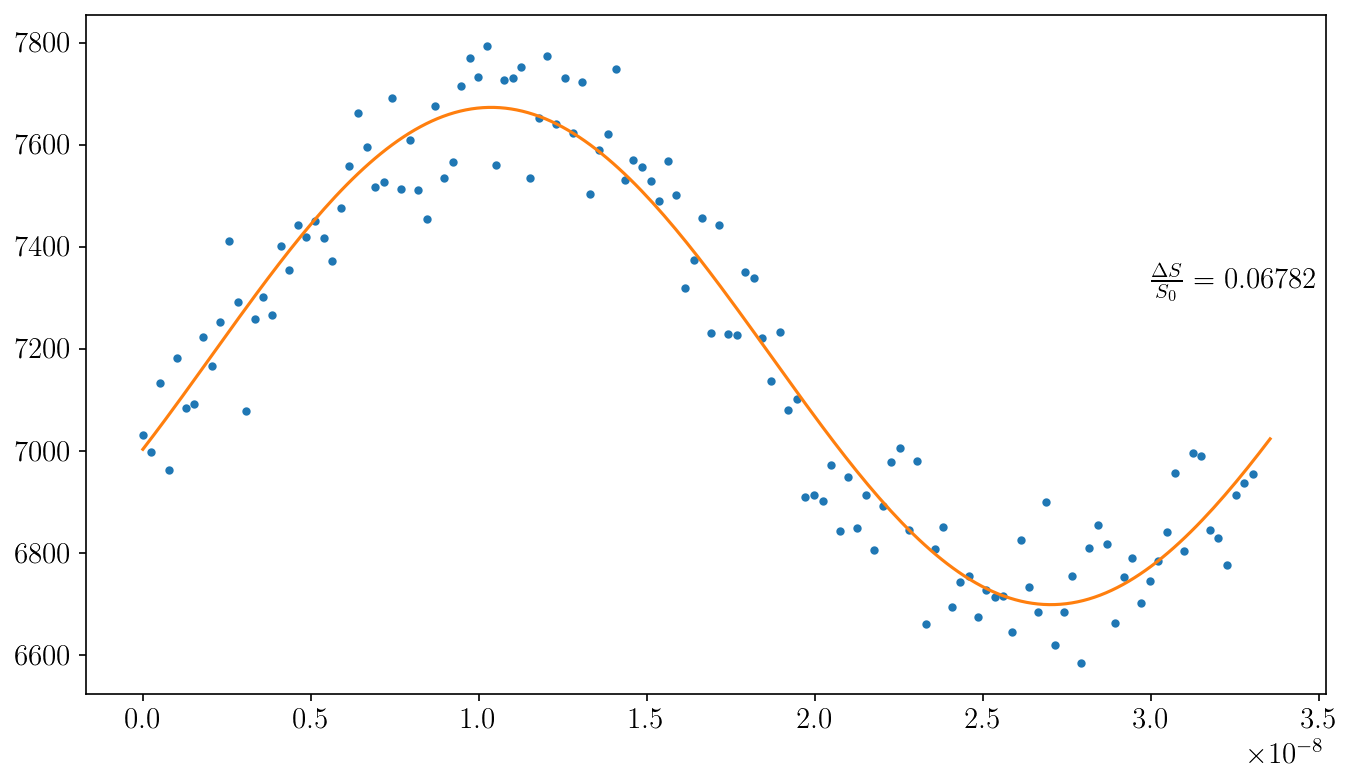

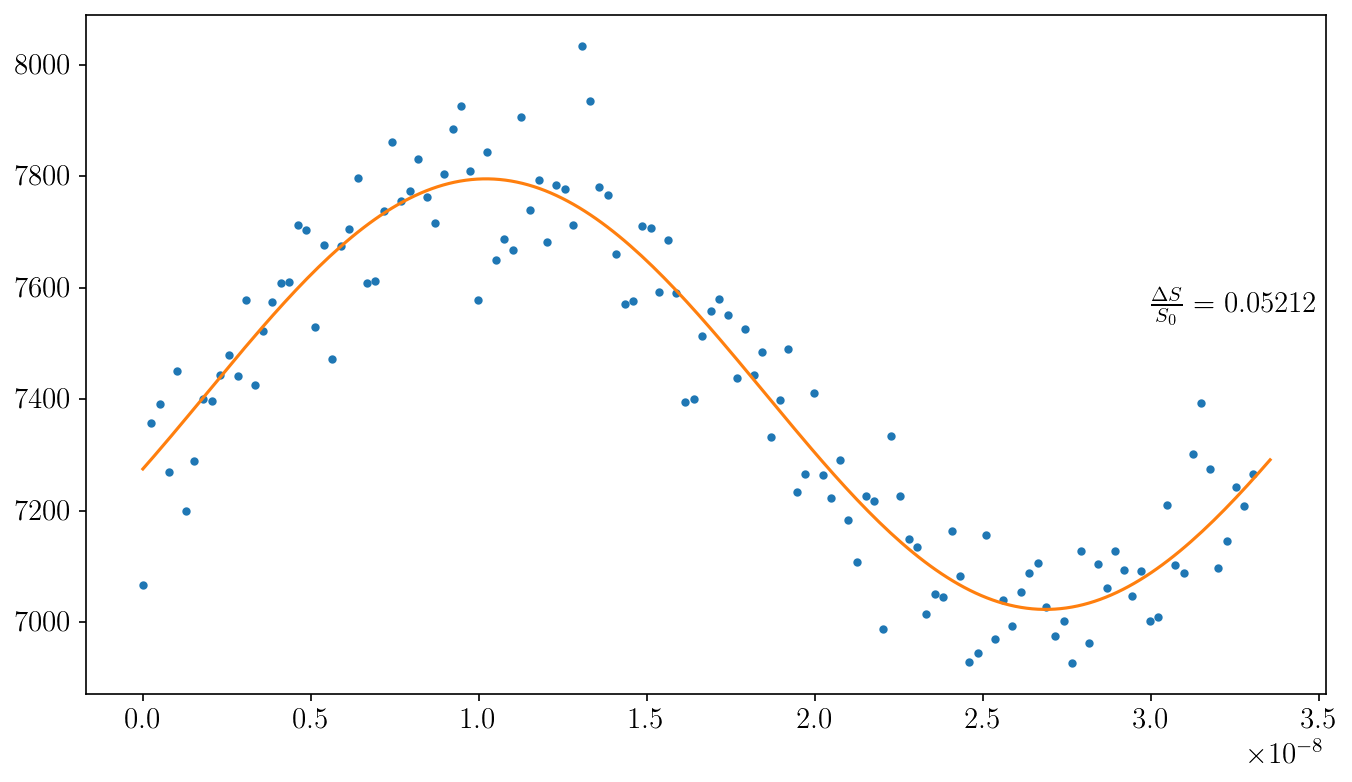

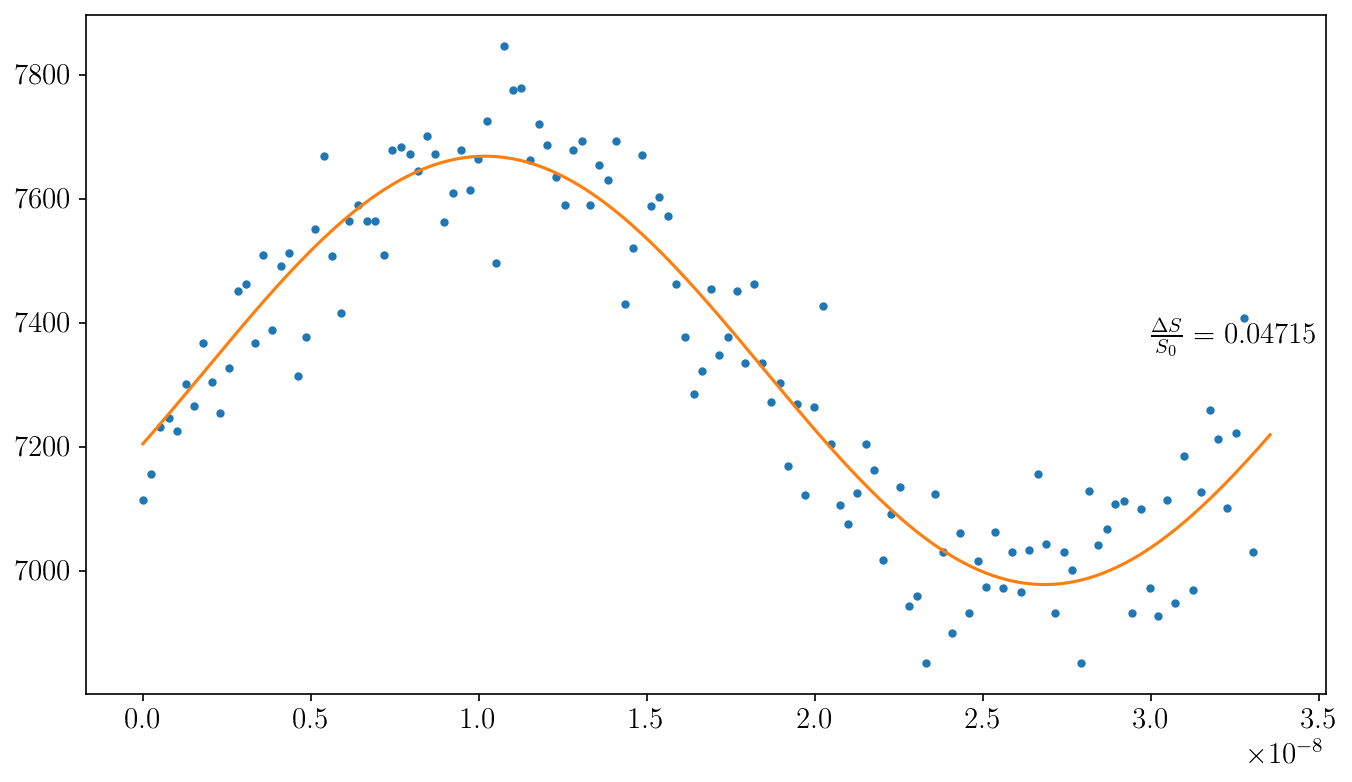

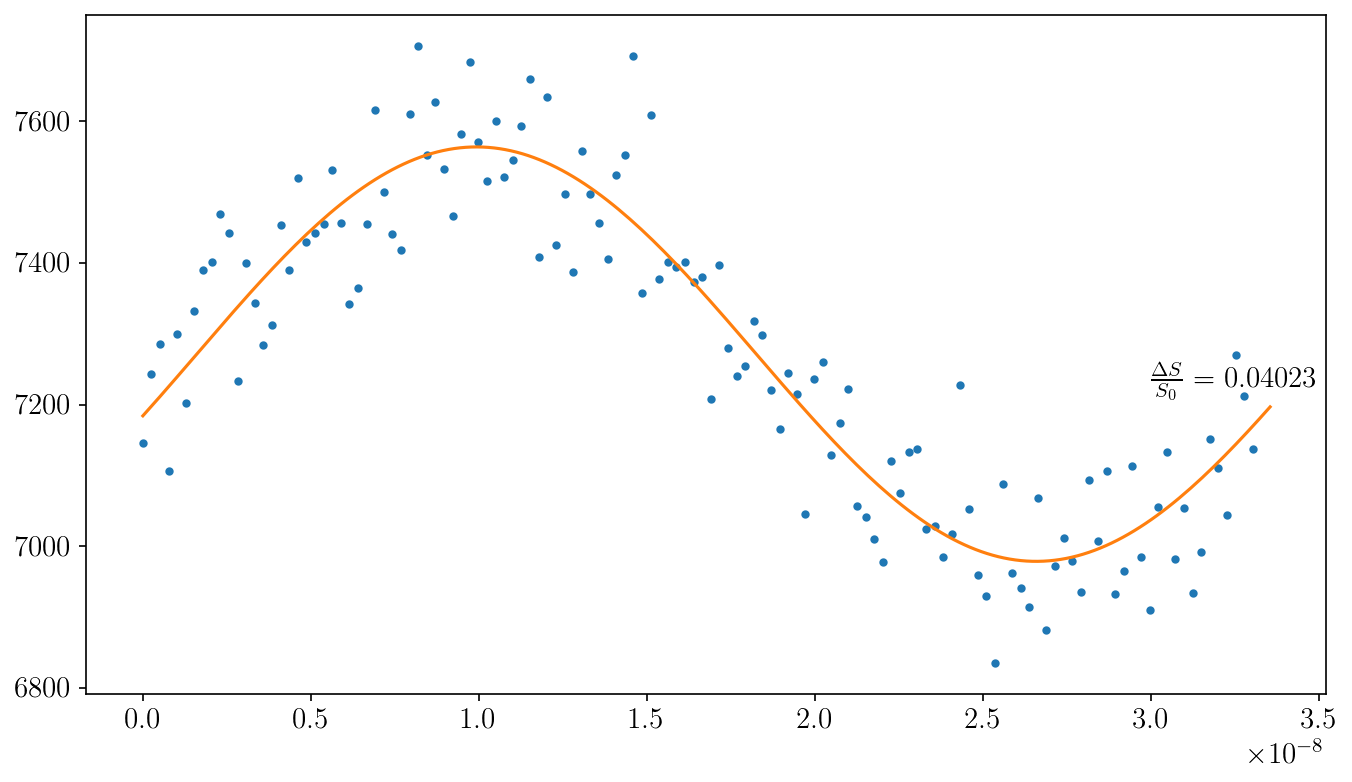

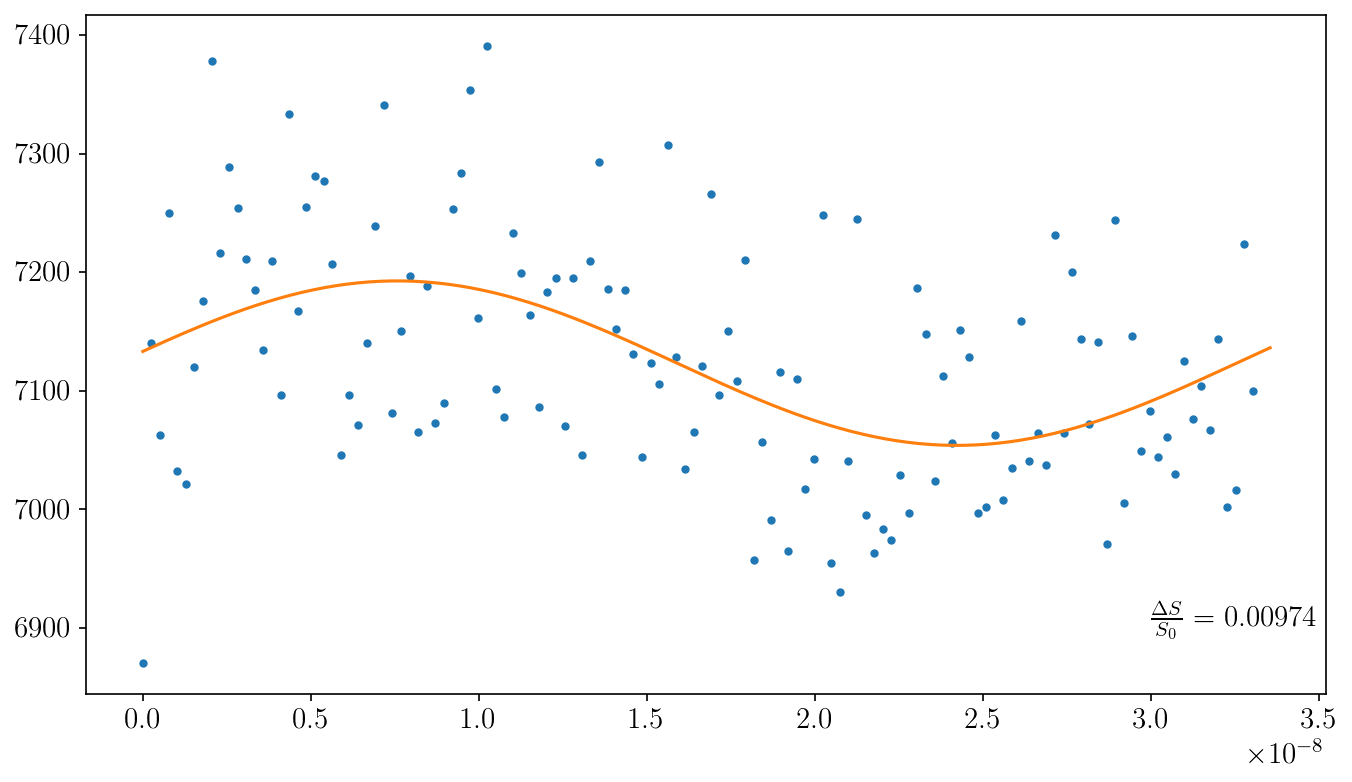

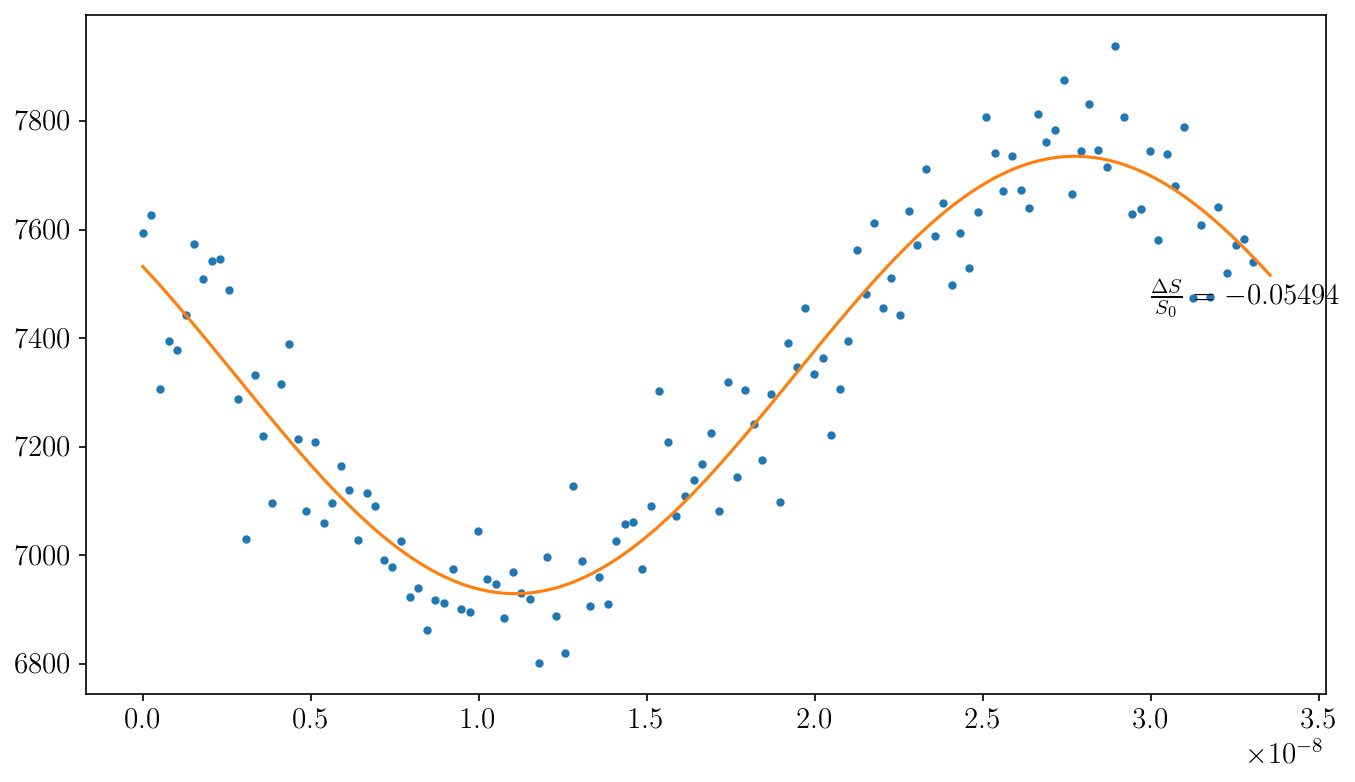

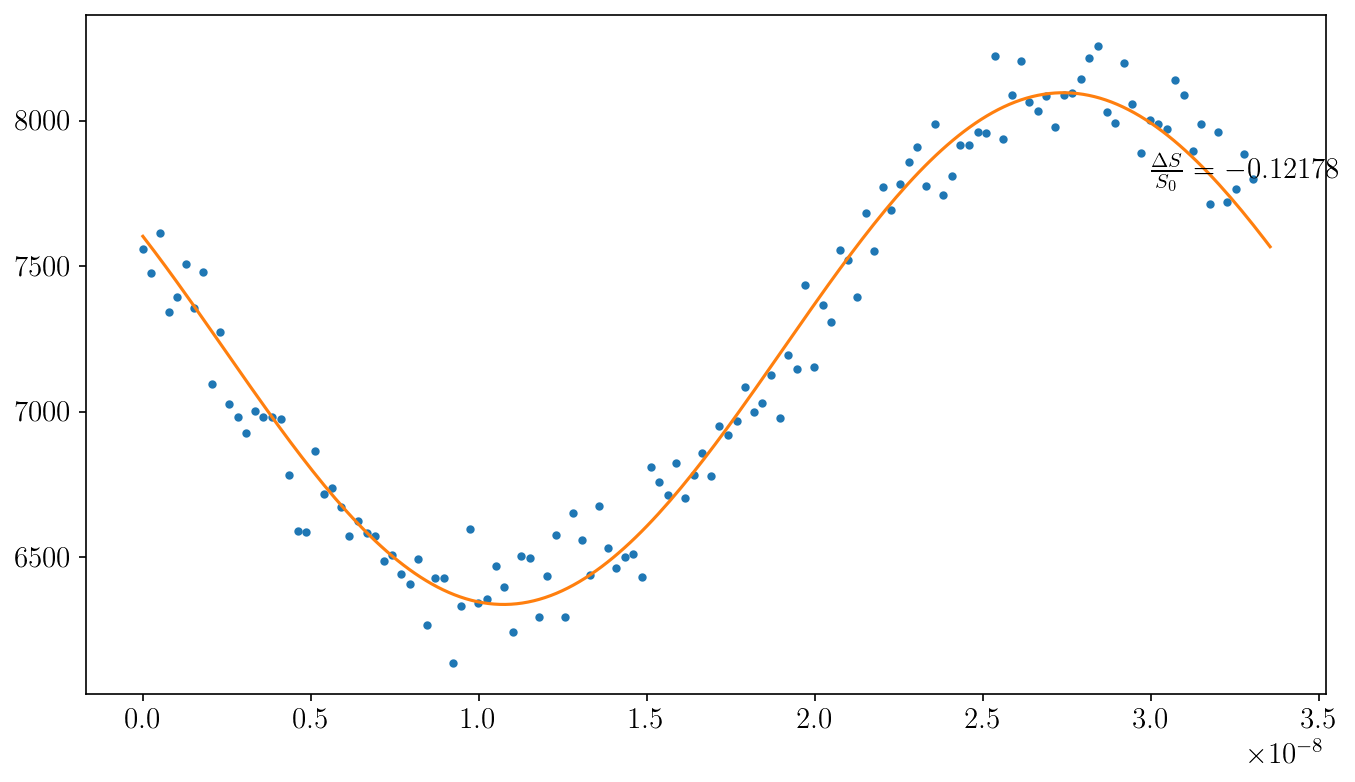

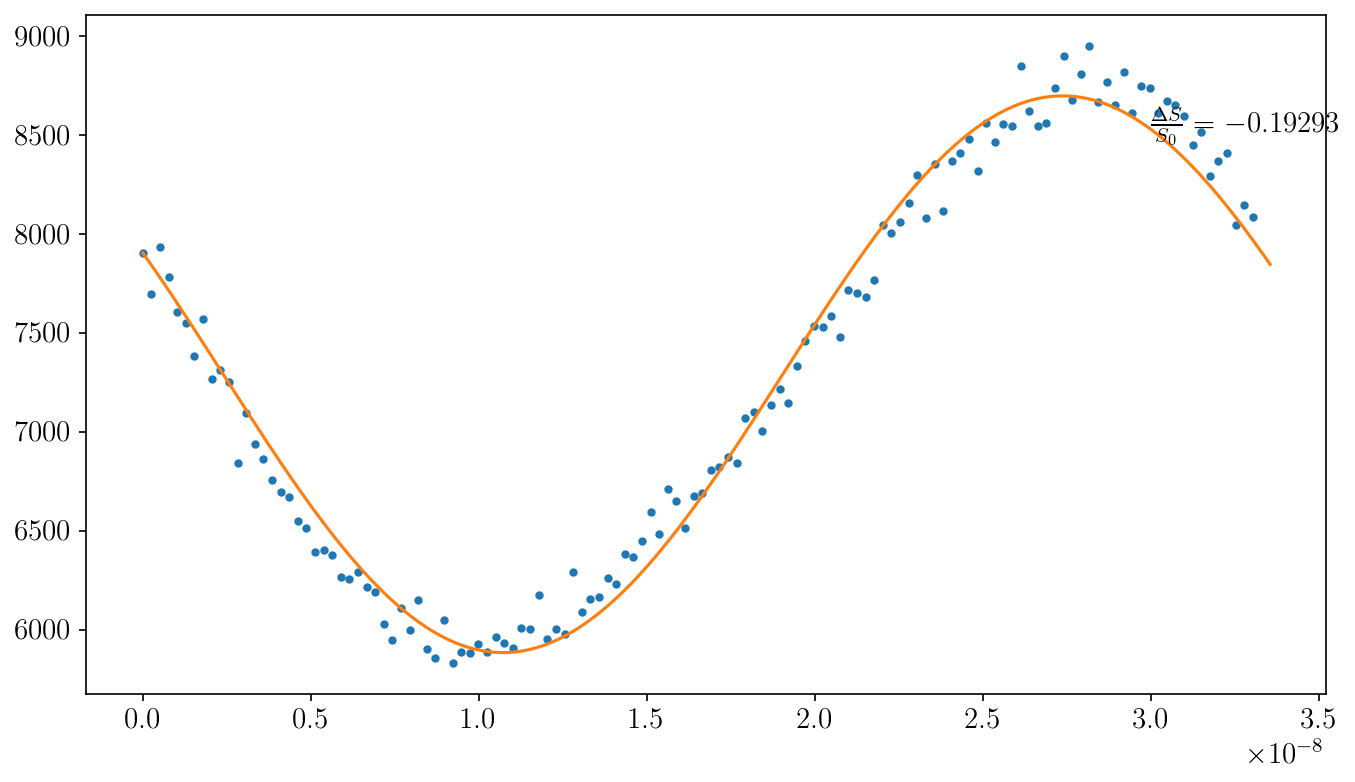

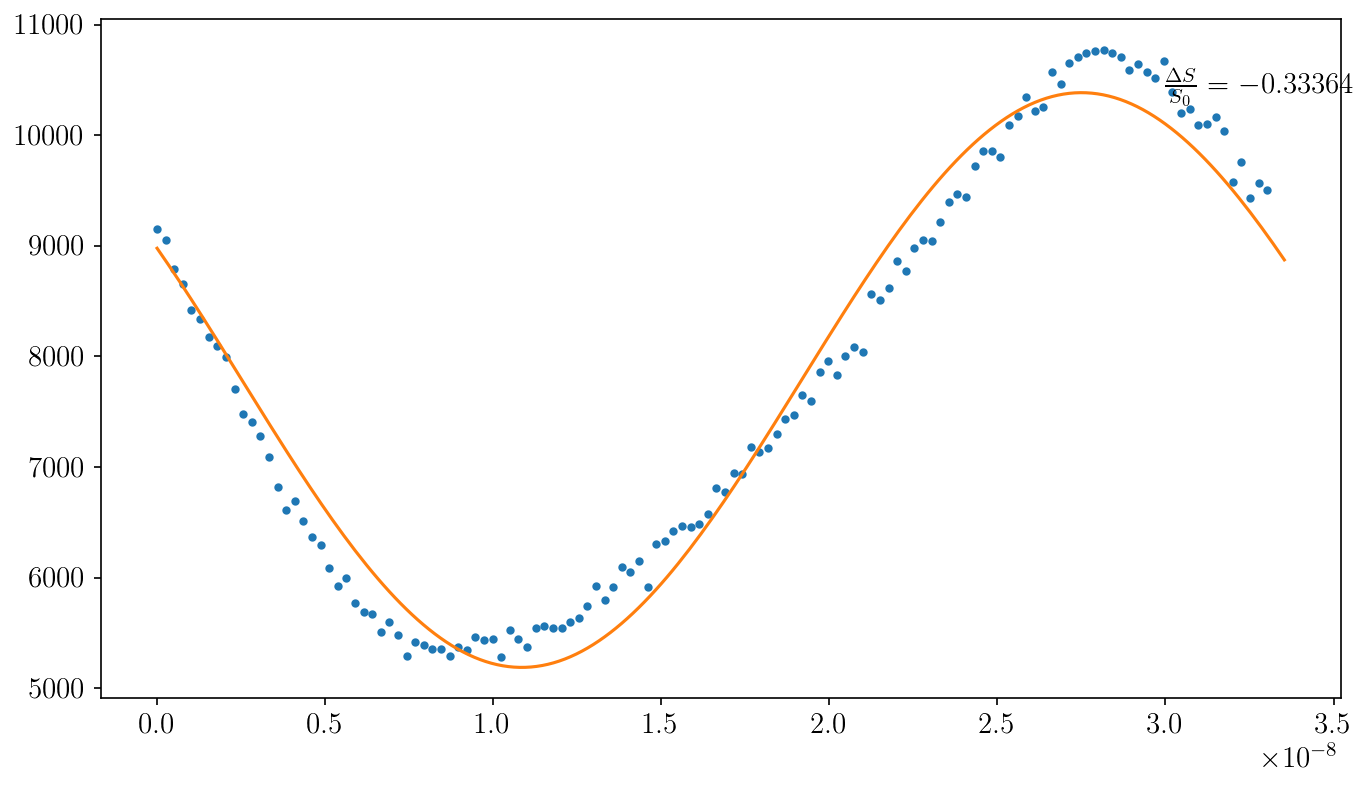

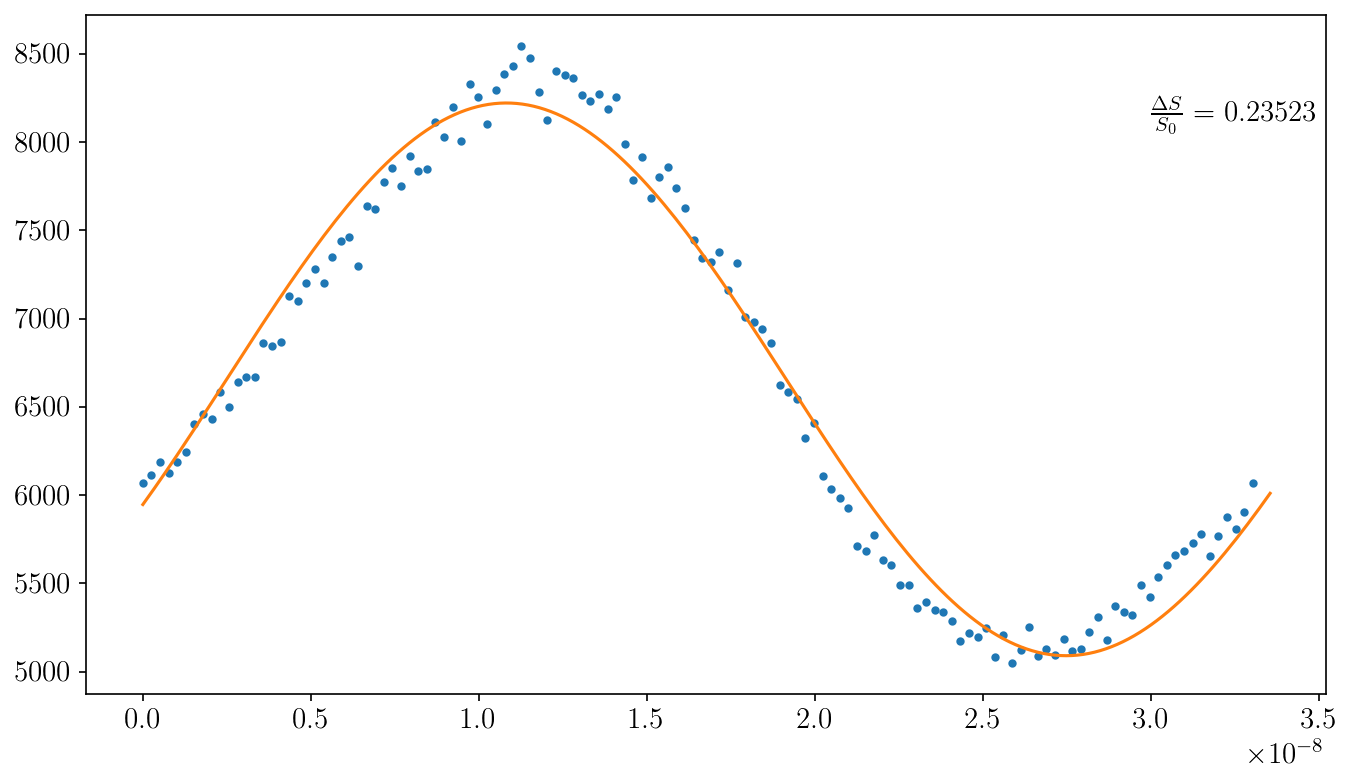

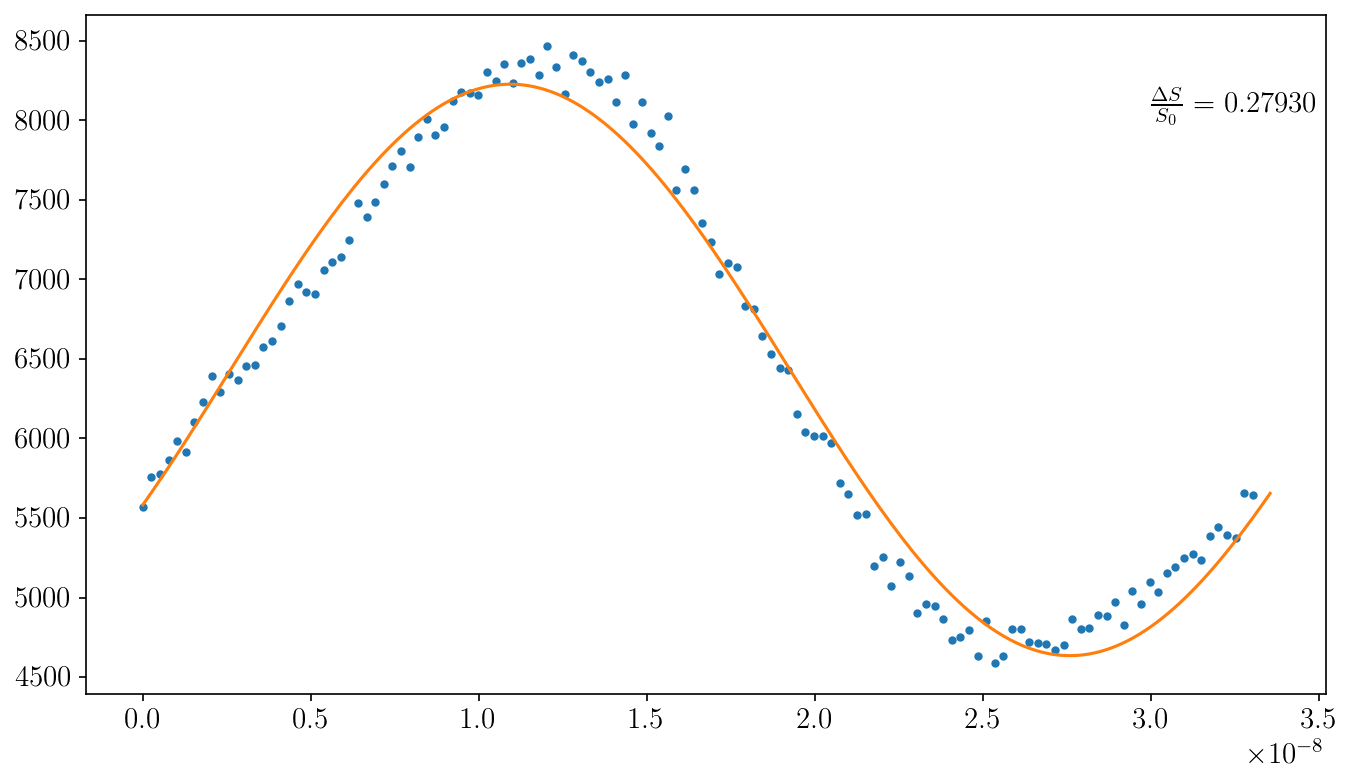

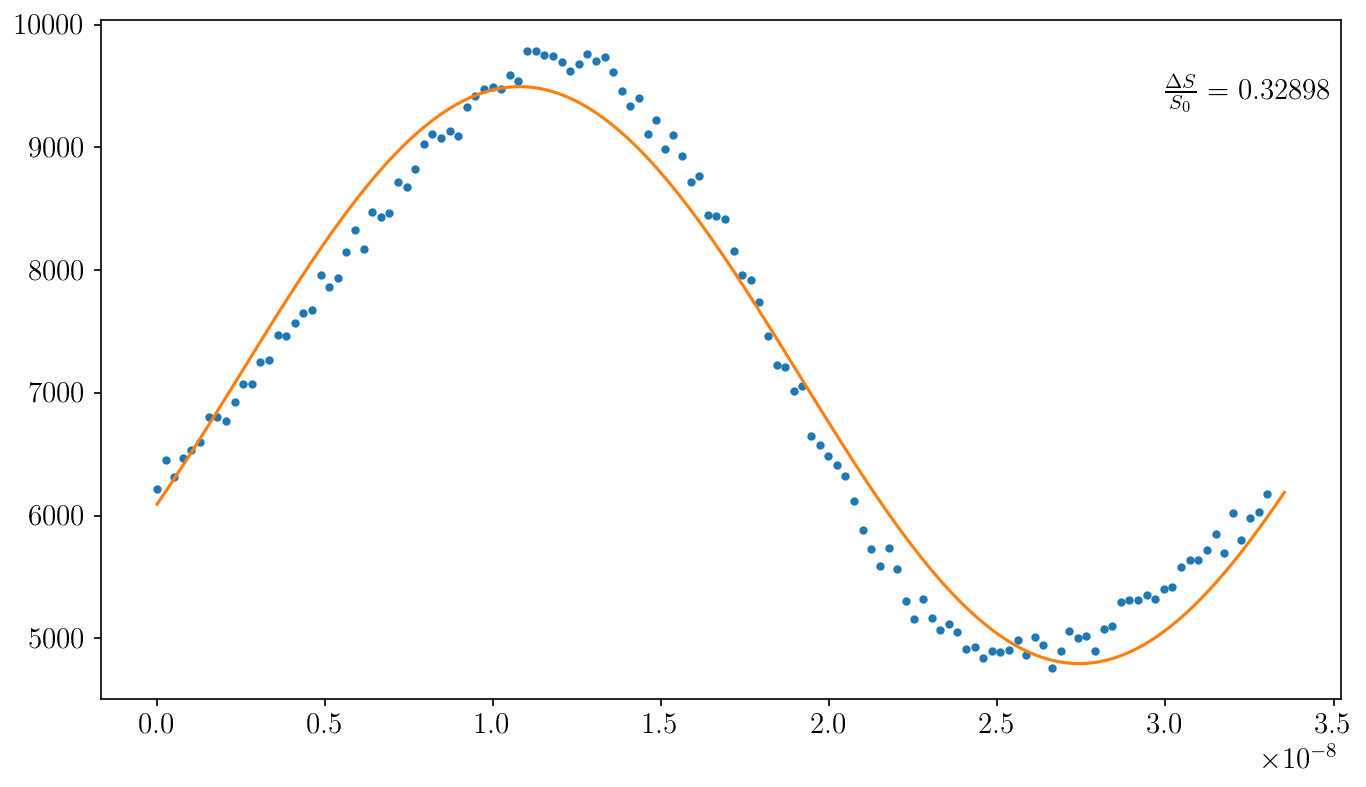

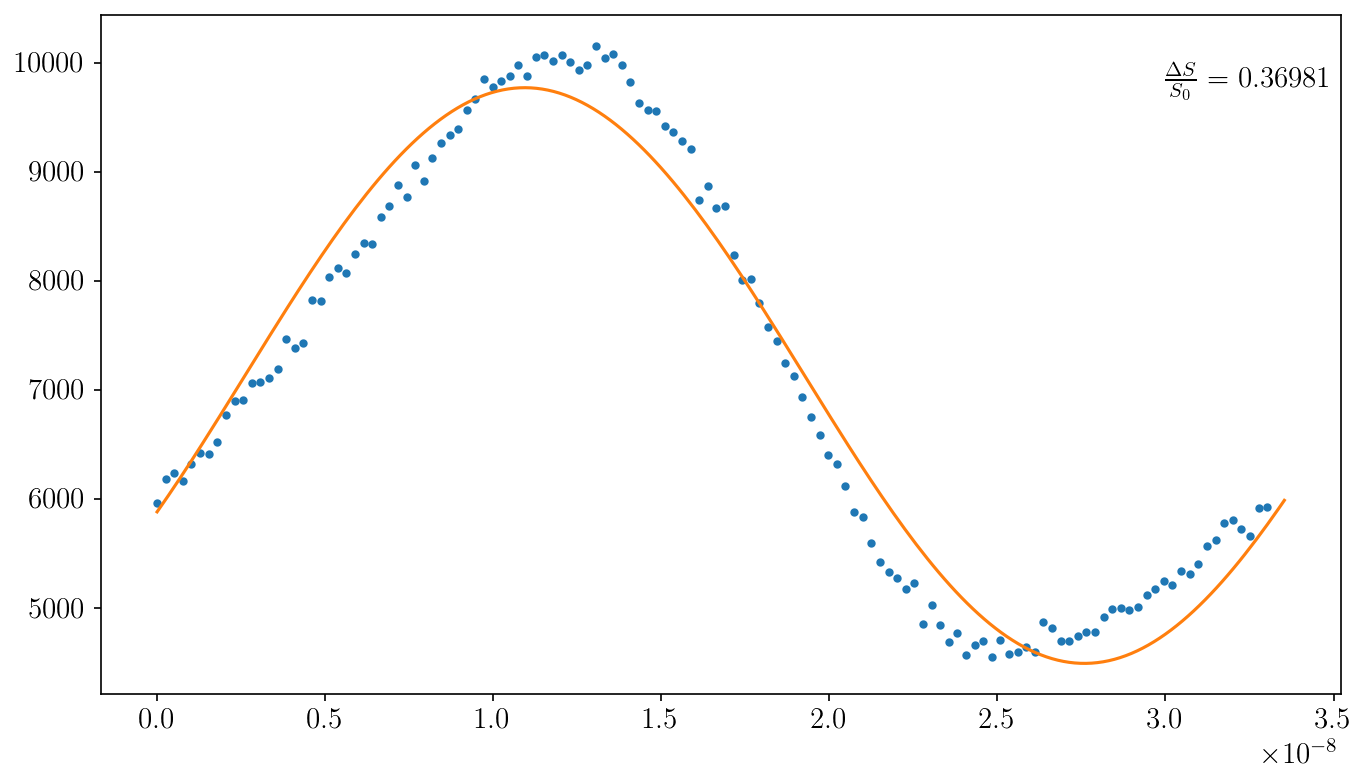

In [9]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.plot(t_scale[:fotkor_shape[0]-2],fotkor_bezcond[:fotkor_shape[0]-2,i],'.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f}$'.format(x[1,i]/x[0,i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-500,text) 

Nejmenší MM vykazuje histogram s indexem 9. Na základě tohoto histogramu odhadnu varianci naměřených bodů. Nejprve od všech bodů histogramu odečtu nafitovanou sinusovku, abych dosáhl pokud možno nemodulovaných dat.

In [11]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,9].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,9].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,9].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,9], t_res) , ftol=1e-10, xtol=1e-10)

In [35]:
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,9] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace

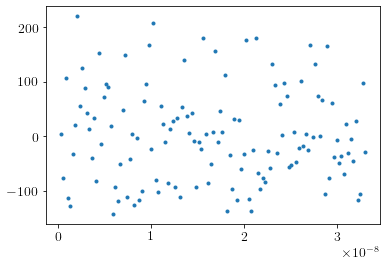

In [36]:
plt.plot(t_scale[1:fotkor_shape[0]-2],fotkor_bezcond_noMM, '.')

to vypada slibne. Ted odhadnu varianci techto bodu.

In [38]:
hist_sigma = np.std(fotkor_bezcond_noMM)
hist_sigma

86.03657527490321

Tuto hodnotu tedy budu predpokladat jako nejistotu bodu histogramu. Ještě ji zkusím ověřit na 8. histogramu.

In [43]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,8].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,8].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,8].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,8], t_res) , ftol=1e-10, xtol=1e-10)
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,8] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace
np.std(fotkor_bezcond_noMM)

81.09953614475

V poradku.

## Fitování histogramů včetně odhadu nejistot

Proces fitování musím upravit tak, abych mohl odhadnout nejistoty, tzn. přidávám váhy. Dále pak budu do grafů přidávat errorbary.

In [44]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) - x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

In [46]:
#from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
    W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    x[:,i] = fit.x
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )